# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Load and explore data

In [4]:
# print dataset shape and missing values
df = pd.read_csv('laptop.csv')
print(f"Dataset Shape: {df.shape}")
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (1303, 13)

Missing Values:
Unnamed: 0.1         0
Unnamed: 0          30
Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64


In [5]:
df.head(5)

,Unnamed: 0.1,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


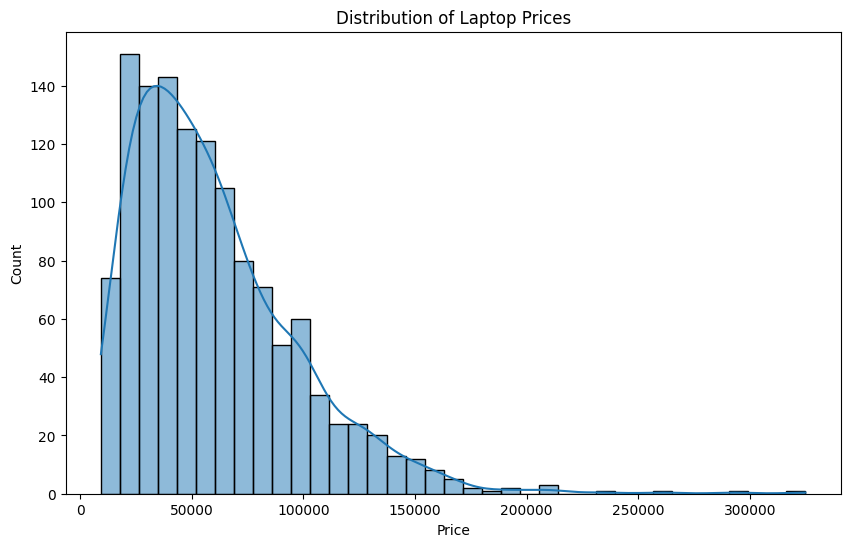

In [6]:
# Visualize price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Laptop Prices')
plt.show()

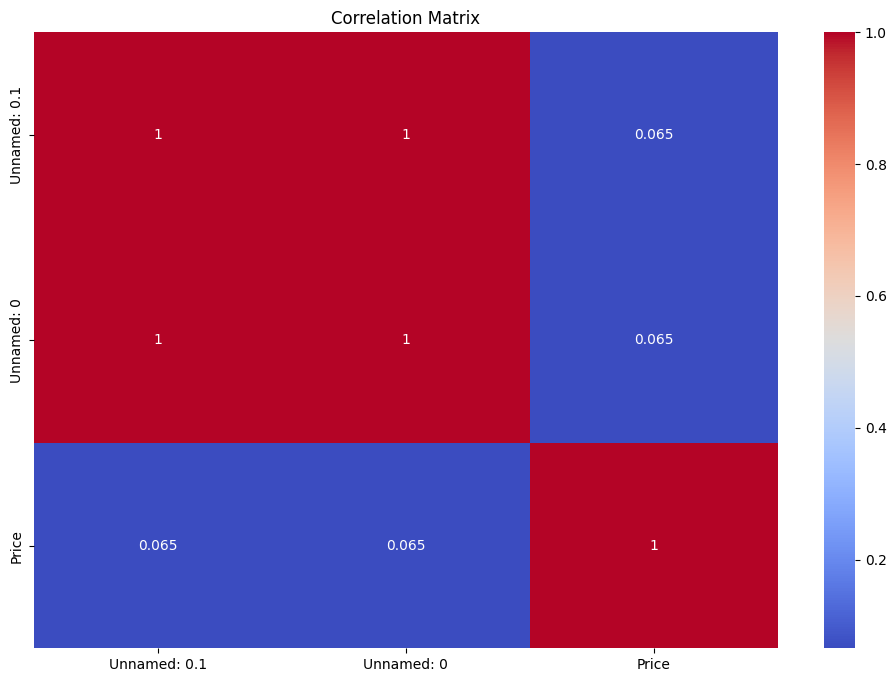

In [7]:
# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Data Preprocessing and Feature Engineering

In [8]:
# Create a copy of the dataframe
df_processed = df.copy()

In [9]:
# Remove unnamed columns
df_processed = df_processed.drop([col for col in df_processed.columns if 'Unnamed' in col], axis=1)

In [10]:
df_processed.shape

(1303, 11)

In [11]:
df_processed.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [12]:
# Remove null values
df_processed = df_processed.dropna()

In [13]:
# Basic preprocessing
df_processed['Ram'] = df_processed['Ram'].str.extract('(\d+)').astype(float)
df_processed['Weight'] = df_processed['Weight'].str.extract('(\d+\.?\d*)').astype(float)

In [14]:
# Create CPU features
df_processed['CPU_Speed'] = df_processed['Cpu'].str.extract('(\d+\.?\d*)GHz').astype(float)
df_processed['CPU_Brand'] = df_processed['Cpu'].apply(lambda x:
    'Intel' if 'Intel' in str(x) else
    'AMD' if 'AMD' in str(x) else 'Other'
)

# Create GPU features
df_processed['GPU_Brand'] = df_processed['Gpu'].apply(lambda x:
    'NVIDIA' if any(brand in str(x).upper() for brand in ['NVIDIA', 'GTX', 'RTX']) else
    'AMD' if any(brand in str(x).upper() for brand in ['AMD', 'RADEON']) else
    'Intel' if 'INTEL' in str(x).upper() else
    'Other'
)

# Other features
df_processed['TouchScreen'] = df_processed['ScreenResolution'].apply(lambda x: 1 if 'Touch' in str(x) else 0)
df_processed['SSD'] = df_processed['Memory'].apply(lambda x: 1 if 'SSD' in str(x) else 0)
df_processed['HDD'] = df_processed['Memory'].apply(lambda x: 1 if 'HDD' in str(x) else 0)

In [15]:
# Process Company
major_companies = ['Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'MSI', 'Microsoft', 'Toshiba']
df_processed['Company'] = df_processed['Company'].apply(lambda x: x if x in major_companies else 'Other')

# Process OS
df_processed['OpSys'] = df_processed['OpSys'].apply(lambda x:
    'Windows' if 'Windows' in str(x) else
    'Mac' if 'Mac' in str(x) else
    'Linux' if 'Linux' in str(x) else
    'Chrome' if 'Chrome' in str(x) else
    'No OS' if 'No OS' in str(x) else
    'Other'
)
df_processed.loc[df_processed['Company'] == 'Apple', 'OpSys'] = 'Mac'

In [16]:
# Handle missing values in numerical features
numerical_features = ['Ram', 'Weight', 'CPU_Speed']
imputer = SimpleImputer(strategy='median')
df_processed[numerical_features] = imputer.fit_transform(df_processed[numerical_features])

In [17]:
df_processed.shape

(1273, 17)

In [18]:
df_processed.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,CPU_Speed,CPU_Brand,GPU_Brand,TouchScreen,SSD,HDD
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,128GB SSD,Intel Iris Plus Graphics 640,Mac,1.37,71378.6832,2.3,Intel,Intel,0,1,0
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,128GB Flash Storage,Intel HD Graphics 6000,Mac,1.34,47895.5232,1.8,Intel,Intel,0,0,0
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,2.5,Intel,Intel,0,1,0
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,512GB SSD,AMD Radeon Pro 455,Mac,1.83,135195.3360,2.7,Intel,AMD,0,1,0
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,256GB SSD,Intel Iris Plus Graphics 650,Mac,1.37,96095.8080,3.1,Intel,Intel,0,1,0


In [19]:
# Define features and target variable
features = ['Company', 'Ram', 'Weight', 'CPU_Brand', 'CPU_Speed',
            'GPU_Brand', 'TouchScreen', 'OpSys', 'SSD', 'HDD']

X = df_processed[features]
y = df_processed['Price']

In [20]:
# Define categorical and numerical feature lists
categorical_features = ['Company', 'CPU_Brand', 'GPU_Brand', 'OpSys']
numerical_features = ['Ram', 'Weight', 'CPU_Speed', 'TouchScreen', 'SSD', 'HDD']

In [21]:
# Create preprocessors
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [22]:
# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [23]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Transform the data using the preprocessor
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [25]:
# Display transformed data shapes
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (1018, 25)
X_test_scaled shape: (255, 25)


# Model Training and Evaluation

# Linear Regression

In [27]:
from time import time
lr_model = LinearRegression()

start_time_lr = time()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

lr_r2 = r2_score(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mape = np.mean(np.abs((y_test - lr_pred) / y_test)) * 100
lr_training_time = time() - start_time_lr

print("\nLinear Regression Results:")
print(f"R² Score: {lr_r2:.4f}")
print(f"MAE: ${lr_mae:.2f}")
print(f"RMSE: ${lr_rmse:.2f}")
print(f"MAPE: {lr_mape:.2f}%")
print(f"Training Time: {lr_training_time:.2f} seconds")


Linear Regression Results:
R² Score: 0.6351
MAE: $16285.06
RMSE: $23006.60
MAPE: 30.32%
Training Time: 0.01 seconds


# Random Forest

In [28]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

start_time_rf = time()
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100
rf_training_time = time() - start_time_rf

print("\nRandom Forest Results:")
print(f"R² Score: {rf_r2:.4f}")
print(f"MAE: ${rf_mae:.2f}")
print(f"RMSE: ${rf_rmse:.2f}")
print(f"MAPE: {rf_mape:.2f}%")
print(f"Training Time: {rf_training_time:.2f} seconds")


Random Forest Results:
R² Score: 0.7537
MAE: $10990.81
RMSE: $18900.84
MAPE: 17.90%
Training Time: 0.38 seconds


# Gradient Boosting

In [29]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1.0,
    max_features=None,
    random_state=42
)

start_time_gb = time()
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)

gb_r2 = r2_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_mape = np.mean(np.abs((y_test - gb_pred) / y_test)) * 100
gb_training_time = time() - start_time_gb

print("\nGradient Boosting Results:")
print(f"R² Score: {gb_r2:.4f}")
print(f"MAE: ${gb_mae:.2f}")
print(f"RMSE: ${gb_rmse:.2f}")
print(f"MAPE: {gb_mape:.2f}%")
print(f"Training Time: {gb_training_time:.2f} seconds")


Gradient Boosting Results:
R² Score: 0.7675
MAE: $12272.17
RMSE: $18365.17
MAPE: 21.11%
Training Time: 0.26 seconds


# Store all Models

In [30]:
model_results = {
    "Linear Regression": {
        "model": lr_model,
        "r2": lr_r2,
        "mae": lr_mae,
        "rmse": lr_rmse,
        "mape": lr_mape,
        "training_time": lr_training_time,
        "predictions": lr_pred
    },
    "Random Forest": {
        "model": rf_model,
        "r2": rf_r2,
        "mae": rf_mae,
        "rmse": rf_rmse,
        "mape": rf_mape,
        "training_time": rf_training_time,
        "predictions": rf_pred
    },
    "Gradient Boosting": {
        "model": gb_model,
        "r2": gb_r2,
        "mae": gb_mae,
        "rmse": gb_rmse,
        "mape": gb_mape,
        "training_time": gb_training_time,
        "predictions": gb_pred
    }
}

# Find Best Model

In [31]:
best_model_name, best_model_data = max(model_results.items(), key=lambda x: x[1]['r2'])

print("\nBest Performing Model:")
print(f"Model: {best_model_name}")
print(f"R² Score: {best_model_data['r2']:.4f}")
print(f"MAE: ${best_model_data['mae']:.2f}")


Best Performing Model:
Model: Gradient Boosting
R² Score: 0.7675
MAE: $12272.17


# Tuning Hyperparameters

## Linear Regression Tuning

In [32]:
def tune_linear_regression(X_train_scaled, y_train):
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    print("\nLinear Regression (No hyperparameters to tune)")
    return lr

## Random Forest Tuning

In [33]:
def tune_random_forest(X_train_scaled, y_train):
    print("\nTuning Random Forest Parameters:")

    param_grid = {
        'n_estimators': [100],
        'max_depth': [10, 15],
        'min_samples_split': [5],
        'min_samples_leaf': [2]
    }

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    print("Best Random Forest Parameters:")
    print(grid_search.best_params_)
    print(f"Best R2 score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

## Gradient Boosting Tuning

In [34]:
def tune_gradient_boosting(X_train_scaled, y_train):
    print("\nTuning Gradient Boosting Parameters:")

    param_grid = {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3, 5],
        'min_samples_split': [5],
        'subsample': [0.8]
    }

    gb = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(
        gb,
        param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    print("Best Gradient Boosting Parameters:")
    print(grid_search.best_params_)
    print(f"Best R2 score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

## Combine Tuning for All Models

In [35]:
def tune_all_models(X_train_scaled, y_train):
    best_models = {}

    try:
        best_models['Linear Regression'] = tune_linear_regression(X_train_scaled, y_train)
        best_models['Random Forest'] = tune_random_forest(X_train_scaled, y_train)
        best_models['Gradient Boosting'] = tune_gradient_boosting(X_train_scaled, y_train)

    except KeyboardInterrupt:
        print("\nTuning interrupted by user. Returning best models found so far")

    return best_models

## Evaluate Tuned Models

In [36]:
def evaluate_tuned_models(best_models, X_test_scaled, y_test):
    print("\nEvaluating Tuned Models:")
    results = {}

    for name, model in best_models.items():
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        results[name] = {
            'model': model,
            'r2': r2,
            'mae': mae
        }

        print(f"\n{name} Results:")
        print(f"R2 Score: {r2:.4f}")
        print(f"MAE: ${mae:.2f}")

    return results

## Final Execution

In [37]:
try:
    best_models = tune_all_models(X_train_scaled, y_train)
    tuned_results = evaluate_tuned_models(best_models, X_test_scaled, y_test)

    best_model_name = max(tuned_results.items(), key=lambda x: x[1]['r2'])[0]
    print(f"\nBest performing model: {best_model_name}")
    print(f"R2 Score: {tuned_results[best_model_name]['r2']:.4f}")
    print(f"MAE: ${tuned_results[best_model_name]['mae']:.2f}")

except KeyboardInterrupt:
    print("\nProcess interrupted by user. Showing partial results if available.")


Linear Regression (No hyperparameters to tune)

Tuning Random Forest Parameters:
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Random Forest Parameters:
{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best R2 score: 0.7311

Tuning Gradient Boosting Parameters:
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Gradient Boosting Parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Best R2 score: 0.7560

Evaluating Tuned Models:

Linear Regression Results:
R2 Score: 0.6351
MAE: $16285.06

Random Forest Results:
R2 Score: 0.7728
MAE: $11304.20

Gradient Boosting Results:
R2 Score: 0.7885
MAE: $11554.87

Best performing model: Gradient Boosting
R2 Score: 0.7885
MAE: $11554.87


## Transform Feature Names

In [38]:
def get_feature_names(preprocessor, original_features):
    feature_names = []

    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(features)
        elif name == 'cat':
            encoded_features = transformer.named_steps['onehot'].get_feature_names_out(features)
            feature_names.extend(encoded_features)

    return feature_names

## Analyzing Feature Importance

In [39]:
def analyze_feature_importance(models, preprocessor, original_features):
    feature_names = get_feature_names(preprocessor, original_features)
    importance_dict = {}

    try:
        for name, model in models.items():
            if name == 'Linear Regression':
                importance = np.abs(model.coef_)
            elif name in ['Random Forest', 'Gradient Boosting']:
                importance = model.feature_importances_

            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importance
            })

            importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
            importance_dict[name] = importance_df

            # Display values
            print(f"\n{name} Feature Importance Values:")
            print(importance_df.to_string(index=True))

            # Plot top 10
            plt.figure(figsize=(10, 6))
            sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
            plt.title(f'{name} - Feature Importance')
            plt.xlabel('Importance')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error in feature importance analysis: {str(e)}")

    return importance_dict

## Analyze & Visualize Across Models


Linear Regression Feature Importance Values:
              Feature    Importance
0       Company_Other  23496.366820
1       Company_Apple  21051.245280
2           OpSys_Mac  21051.245280
3         OpSys_No OS  18369.773159
4   Company_Microsoft  17114.759083
5          Company_HP  16975.177477
6                 SSD  15480.720265
7           CPU_Speed  15449.085618
8     Company_Toshiba  14911.403315
9         Company_MSI  14171.244329
10   GPU_Brand_NVIDIA  13733.636180
11    CPU_Brand_Intel  13551.617297
12        TouchScreen  13370.603706
13       Company_Dell  12691.308461
14     Company_Lenovo  10100.945976
15        OpSys_Linux   9068.352949
16    GPU_Brand_Intel   8153.015022
17       Company_Asus   7801.444637
18                Ram   2918.549336
19             Weight   2668.493304
20        OpSys_Other   2417.742849
21      OpSys_Windows   1353.082640
22                HDD   1347.634655
23    GPU_Brand_Other    936.636880
24    CPU_Brand_Other    936.636880


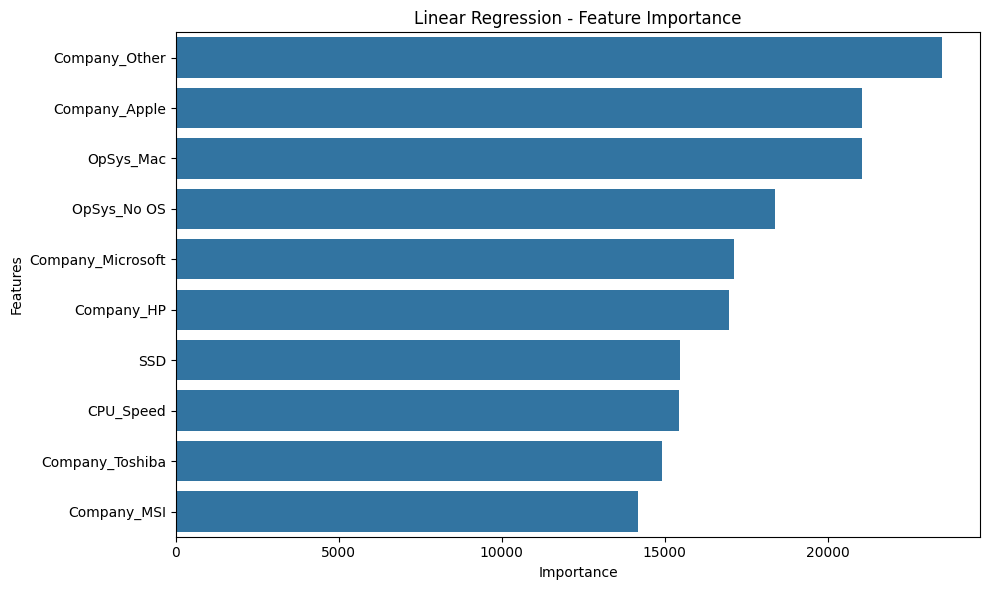


Random Forest Feature Importance Values:
              Feature  Importance
0                 Ram    0.608469
1              Weight    0.162121
2           CPU_Speed    0.117365
3                 SSD    0.021772
4         TouchScreen    0.010562
5       Company_Other    0.009703
6                 HDD    0.009667
7          Company_HP    0.008784
8       OpSys_Windows    0.008504
9        Company_Dell    0.008481
10       Company_Asus    0.006928
11     Company_Lenovo    0.006848
12    GPU_Brand_Intel    0.005556
13   GPU_Brand_NVIDIA    0.004913
14    CPU_Brand_Intel    0.004681
15        Company_MSI    0.003134
16        OpSys_No OS    0.000749
17    Company_Toshiba    0.000631
18          OpSys_Mac    0.000454
19        OpSys_Linux    0.000370
20      Company_Apple    0.000280
21  Company_Microsoft    0.000028
22    CPU_Brand_Other    0.000000
23    GPU_Brand_Other    0.000000
24        OpSys_Other    0.000000


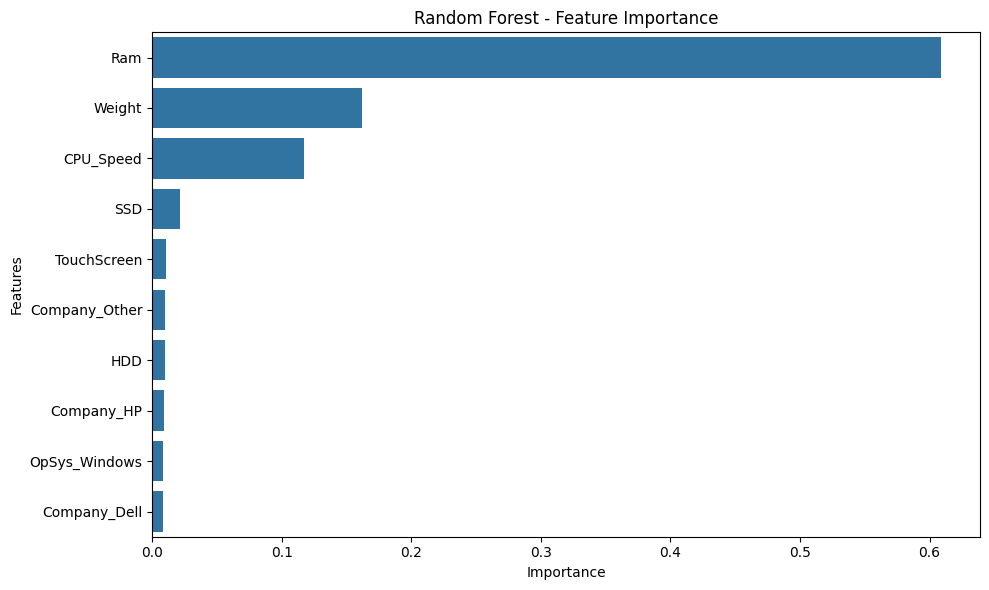


Gradient Boosting Feature Importance Values:
              Feature  Importance
0                 Ram    0.552999
1              Weight    0.161036
2           CPU_Speed    0.125382
3                 SSD    0.030658
4       Company_Other    0.025023
5          Company_HP    0.016977
6         TouchScreen    0.011253
7     CPU_Brand_Intel    0.010164
8                 HDD    0.009755
9    GPU_Brand_NVIDIA    0.009525
10      OpSys_Windows    0.009335
11       Company_Dell    0.008529
12       Company_Asus    0.007337
13     Company_Lenovo    0.005512
14        Company_MSI    0.004440
15    GPU_Brand_Intel    0.003786
16        OpSys_No OS    0.002285
17        OpSys_Linux    0.001882
18          OpSys_Mac    0.001587
19      Company_Apple    0.001338
20    Company_Toshiba    0.000720
21  Company_Microsoft    0.000416
22    CPU_Brand_Other    0.000038
23    GPU_Brand_Other    0.000024
24        OpSys_Other    0.000000


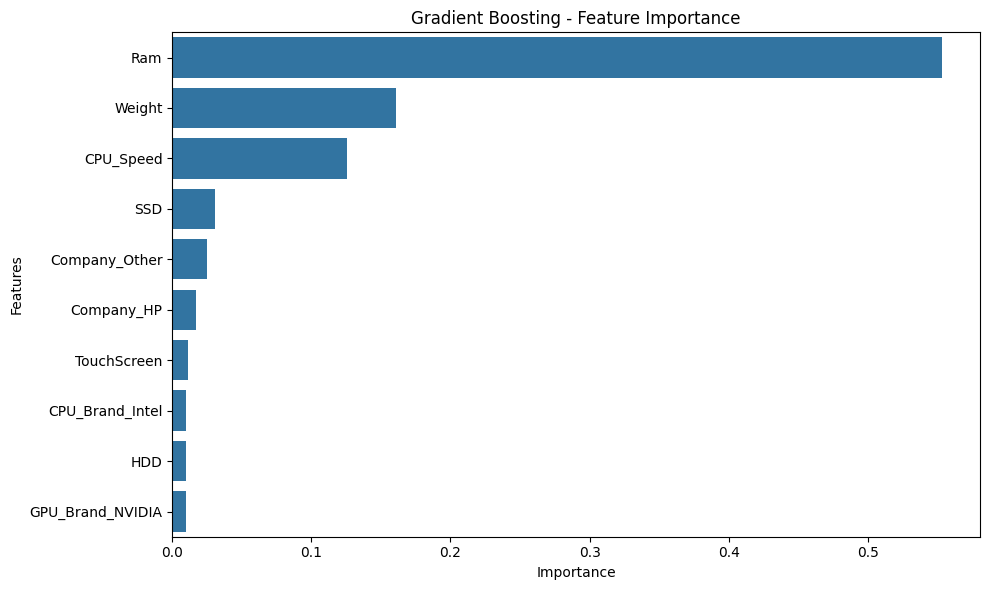

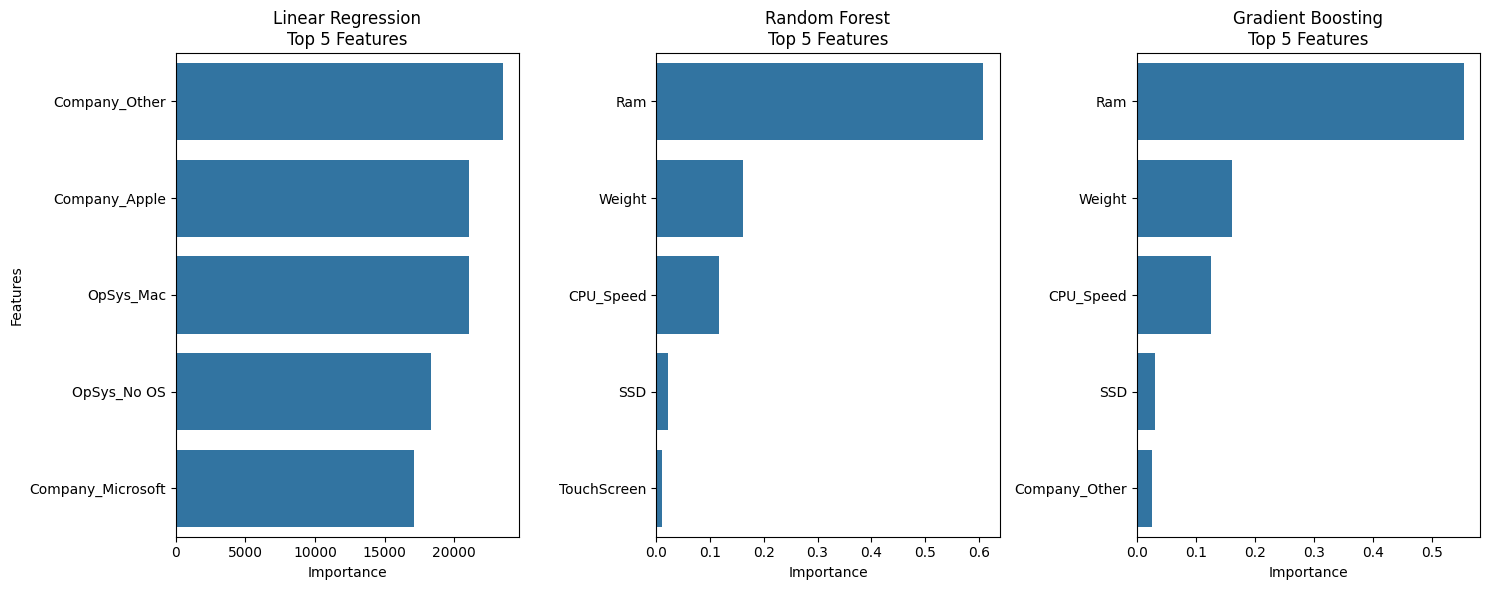

In [40]:
try:
    original_features = ['Company', 'Ram', 'Weight', 'CPU_Brand', 'CPU_Speed',
                         'GPU_Brand', 'TouchScreen', 'OpSys', 'SSD', 'HDD']

    importance_dict = analyze_feature_importance(best_models, preprocessor, original_features)

    # Compare top 5 features across models
    plt.figure(figsize=(15, 6))
    model_names = list(importance_dict.keys())

    for i, model_name in enumerate(model_names):
        top_features = importance_dict[model_name].head(5)

        plt.subplot(1, len(model_names), i+1)
        sns.barplot(data=top_features, x='Importance', y='Feature')
        plt.title(f'{model_name}\nTop 5 Features')
        plt.xlabel('Importance')
        if i == 0:
            plt.ylabel('Features')
        else:
            plt.ylabel('')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in visualization: {str(e)}")

# Real Time Prediction

## Laptop Specification Collector

In [41]:
def create_laptop_input():
    print("\nEnter Laptop Specifications:")

    company_options = {
        0: 'Acer', 1: 'Apple', 2: 'Asus', 3: 'Dell', 4: 'HP',
        5: 'Lenovo', 6: 'MSI', 7: 'Microsoft', 8: 'Toshiba', 9: 'Other'
    }
    print("\nCompany Options:")
    for key, value in company_options.items():
        print(f"{key}: {value}")
    company = company_options[int(input("Enter company number: "))]

    ram_options = [4, 8, 16, 32, 64]
    print("\nRAM Options (GB):")
    for i, ram in enumerate(ram_options):
        print(f"{i}: {ram}GB")
    ram = ram_options[int(input("Enter RAM choice: "))]

    weight = float(input("\nEnter Weight (kg): "))

    cpu_options = {0: 'Intel', 1: 'AMD', 2: 'Other'}
    print("\nCPU Brand Options:")
    for key, value in cpu_options.items():
        print(f"{key}: {value}")
    cpu_brand = cpu_options[int(input("Enter CPU brand number: "))]

    print("\nTypical CPU Speed ranges:")
    print("1.8 GHz - 2.2 GHz (Low Power)")
    print("2.3 GHz - 2.8 GHz (Mid Range)")
    print("2.9 GHz - 3.6 GHz (High Performance)")
    cpu_speed = float(input("\nEnter CPU Speed (GHz): "))

    gpu_options = {0: 'NVIDIA', 1: 'AMD', 2: 'Intel', 3: 'Other'}
    print("\nGPU Brand Options:")
    for key, value in gpu_options.items():
        print(f"{key}: {value}")
    gpu_brand = gpu_options[int(input("Enter GPU brand number: "))]

    touchscreen = int(input("\nTouchscreen (0: No, 1: Yes): "))

    os_options = {
        0: 'Windows', 1: 'Mac', 2: 'Linux', 3: 'Chrome',
        4: 'No OS', 5: 'Other'
    }
    print("\nOperating System Options:")
    for key, value in os_options.items():
        print(f"{key}: {value}")
    os = os_options[int(input("Enter OS number: "))]

    print("\nStorage Options:")
    ssd = int(input("SSD (0: No, 1: Yes): "))
    hdd = int(input("HDD (0: No, 1: Yes): "))

    new_laptop = pd.DataFrame([[
        company, ram, weight, cpu_brand, cpu_speed,
        gpu_brand, touchscreen, os, ssd, hdd
    ]], columns=['Company', 'Ram', 'Weight', 'CPU_Brand', 'CPU_Speed',
                 'GPU_Brand', 'TouchScreen', 'OpSys', 'SSD', 'HDD'])

    # Confirmation
    print("\nSelected Specifications:")
    for col in new_laptop.columns:
        val = new_laptop.at[0, col]
        print(f"{col}: {val if not isinstance(val, int) else ('Yes' if val == 1 else 'No') if col in ['SSD', 'HDD', 'TouchScreen'] else val}")

    confirm = input("\nConfirm specifications? (yes/no): ")
    return new_laptop if confirm.lower() == 'yes' else create_laptop_input()

## Prediction Function

In [42]:
def predict_price(models, preprocessor, new_laptop):
    predictions = {}
    try:
        new_laptop_transformed = preprocessor.transform(new_laptop)
        for name, model in models.items():
            predictions[name] = model.predict(new_laptop_transformed)[0]
        return predictions
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None

## Prediction Output Formatter

In [43]:
def display_prediction_results(predictions):
    if predictions:
        print("\nPredicted Prices:")
        prices = list(predictions.values())
        avg_price = np.mean(prices)
        min_price = np.min(prices)
        max_price = np.max(prices)

        for model_name, price in predictions.items():
            print(f"{model_name}: ${price:,.2f}")

        print("\nSummary:")
        print(f"Average Price: ${avg_price:,.2f}")
        print(f"Price Range: ${min_price:,.2f} - ${max_price:,.2f}")
    else:
        print("Unable to make predictions. Please check the input values.")

## Main Execution Block

In [45]:
try:
    new_laptop = create_laptop_input()
    predictions = predict_price(best_models, preprocessor, new_laptop)
    display_prediction_results(predictions)
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please try again.")


Enter Laptop Specifications:

Company Options:
0: Acer
1: Apple
2: Asus
3: Dell
4: HP
5: Lenovo
6: MSI
7: Microsoft
8: Toshiba
9: Other


Enter company number:  4



RAM Options (GB):
0: 4GB
1: 8GB
2: 16GB
3: 32GB
4: 64GB


Enter RAM choice:  1

Enter Weight (kg):  1.6



CPU Brand Options:
0: Intel
1: AMD
2: Other


Enter CPU brand number:  0



Typical CPU Speed ranges:
1.8 GHz - 2.2 GHz (Low Power)
2.3 GHz - 2.8 GHz (Mid Range)
2.9 GHz - 3.6 GHz (High Performance)



Enter CPU Speed (GHz):  2.2



GPU Brand Options:
0: NVIDIA
1: AMD
2: Intel
3: Other


Enter GPU brand number:  2

Touchscreen (0: No, 1: Yes):  1



Operating System Options:
0: Windows
1: Mac
2: Linux
3: Chrome
4: No OS
5: Other


Enter OS number:  0



Storage Options:


SSD (0: No, 1: Yes):  1
HDD (0: No, 1: Yes):  0



Selected Specifications:
Company: HP
Ram: 8
Weight: 1.6
CPU_Brand: Intel
CPU_Speed: 2.2
GPU_Brand: Intel
TouchScreen: 1
OpSys: Windows
SSD: 1
HDD: 0



Confirm specifications? (yes/no):  yes



Predicted Prices:
Linear Regression: $78,514.16
Random Forest: $52,287.01
Gradient Boosting: $58,846.92

Summary:
Average Price: $63,216.03
Price Range: $52,287.01 - $78,514.16
